In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,cv2
from IPython.display import Image
from keras.preprocessing import image
from keras import optimizers
from keras import layers,models
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16


import numpy as np

Using TensorFlow backend.


In [2]:
print(os.listdir("../cactus/"))

['.ipynb_checkpoints', 'aerial-cactus-identification.zip', 'cactus.ipynb', 'cactus32.ipynb', 'cactus32_transferLearning.ipynb', 'ML_CNN_Augmentation.csv', 'ML_CNN_Transfer.csv', 'sample_submission.csv', 'test', 'test.zip', 'train', 'train.csv', 'train.zip']


In [ ]:
## Descompactando os arquivos zipados
with zipfile.ZipFile("../input/aerial-cactus-identification/train.zip","r") as z:
    z.extractall(".")

with zipfile.ZipFile("../input/aerial-cactus-identification/test.zip","r") as z:
    z.extractall(".")  

In [3]:
# Atribuindo os arquivos e diretórios a variáveis para futuras análises
train_dir="../cactus/train"
test_dir="../cactus/test/"
train=pd.read_csv('../cactus/train.csv')

df_test=pd.read_csv('../cactus/sample_submission.csv')

In [4]:
#Localizando GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3419536287246100962
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1931594374923591529
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3055235891
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11348909199892486096
physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5795924634227655700
physical_device_desc: "device: XLA_GPU device"
]


In [5]:
import tensorflow as tf

In [6]:
# Imprimindo uma amostra do nosso dataset de treino
train.head(5)

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [7]:
# Conversão da coluna 'has_cactus' em string para realizar a separação dos dados
train.has_cactus=train.has_cactus.astype(str)


In [8]:
#Quantidade de linhas e colunas do df
train.shape

(17500, 2)

In [9]:
#Quantos registros são cactus e quantos nao são
train['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

In [139]:
# quantidade de registros de teste
print("Quantidade de linhas em teste: %d"%(len(os.listdir('../cactus/test'))))

Quantidade de linhas em teste: 4000


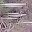

In [11]:
#Imagens do dataset
Image(os.path.join("../cactus/train",train.iloc[0,0]),width=250,height=250)

In [132]:
#Transforma os dados de entrada / utilizado para Augmentation

#Rescale: Altera o dimensionamento da imagem, os dados originais são multiplixados pelo valor setado
#rotation_range: Rotação de 20 graus nas imagens, 
#horizontal_flip: Reverter linhas <->
#shear_range: Estica a imagem
datagen=ImageDataGenerator(rescale=1./255, rotation_range=20,horizontal_flip=True, shear_range = 0.2,zoom_range = 0.2)


In [133]:
#Leitura dos dados presentes no diretório Train_dir de acordo com o dataframe de treino, subdividindo em treino e validação
train_generator=datagen.flow_from_dataframe(dataframe=train[:15001],directory=train_dir,x_col='id',
                                            y_col='has_cactus',class_mode='binary',
                                            target_size=(32,32))


validation_generator=datagen.flow_from_dataframe(dataframe=train[15001:],directory=train_dir,x_col='id',
                                                y_col='has_cactus',class_mode='binary',
                                                target_size=(32,32))



Found 15001 validated image filenames belonging to 2 classes.
Found 2499 validated image filenames belonging to 2 classes.


In [141]:
#CNN sem utilização de tranfer learning
with tf.device('/GPU:0'):
    model=models.Sequential()
    model.add(layers.Conv2D(32,(3,3),activation='relu', input_shape = (32,32,3)))
    model.add(layers.MaxPool2D((2,2)))
    model.add(layers.Conv2D(64,(3,3),activation='relu', input_shape = (32,32,3)))
    model.add(layers.MaxPool2D((2,2)))
    model.add(layers.Conv2D(128,(3,3),activation='relu', input_shape = (32,32,3)))
    model.add(layers.MaxPool2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512,activation='relu'))
    model.add(layers.Dense(1,activation='sigmoid'))

In [142]:
#Verificaçao da arquitetura da CNN:
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 512)             

In [143]:
# Compilando a CNN
model.compile(loss='binary_crossentropy',optimizer=optimizers.rmsprop(),metrics=['acc'])

In [144]:
# Executando o treinamento (sem VGG16)

with tf.device('/GPU:0'):
    epochs=10
    history=model.fit_generator(train_generator,steps_per_epoch=1000,epochs=10,validation_data=validation_generator,validation_steps=700)

Epoch 1/10
1000/1000 [==============================] - 48s 48ms/step - loss: 0.2170 - acc: 0.9144 - val_loss: 0.2303 - val_acc: 0.9640
Epoch 2/10
1000/1000 [==============================] - 50s 50ms/step - loss: 0.1254 - acc: 0.9542 - val_loss: 0.1079 - val_acc: 0.9566
Epoch 3/10
1000/1000 [==============================] - 50s 50ms/step - loss: 0.1106 - acc: 0.9635 - val_loss: 0.0937 - val_acc: 0.9385
Epoch 4/10
1000/1000 [==============================] - 51s 51ms/step - loss: 0.1012 - acc: 0.9679 - val_loss: 0.1459 - val_acc: 0.9768
Epoch 5/10
1000/1000 [==============================] - 47s 47ms/step - loss: 0.1008 - acc: 0.9710 - val_loss: 0.0022 - val_acc: 0.9771
Epoch 6/10
1000/1000 [==============================] - 47s 47ms/step - loss: 0.0913 - acc: 0.9725 - val_loss: 0.2721 - val_acc: 0.9150
Epoch 7/10
1000/1000 [==============================] - 47s 47ms/step - loss: 0.0867 - acc: 0.9749 - val_loss: 0.0326 - val_acc: 0.9802
Epoch 8/10
1000/1000 [==========================

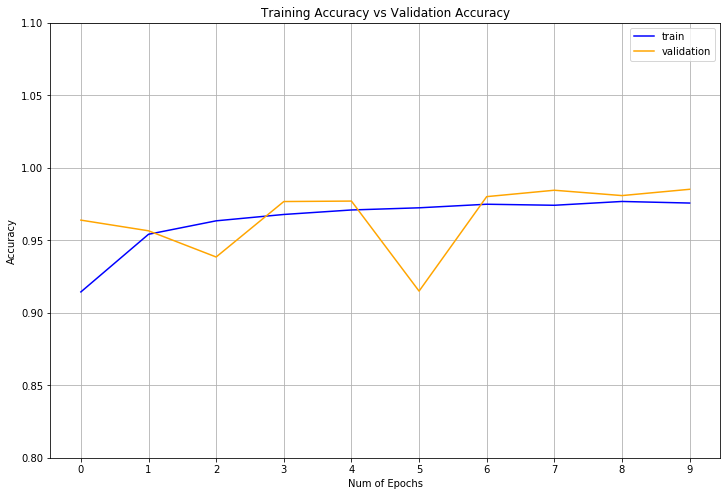

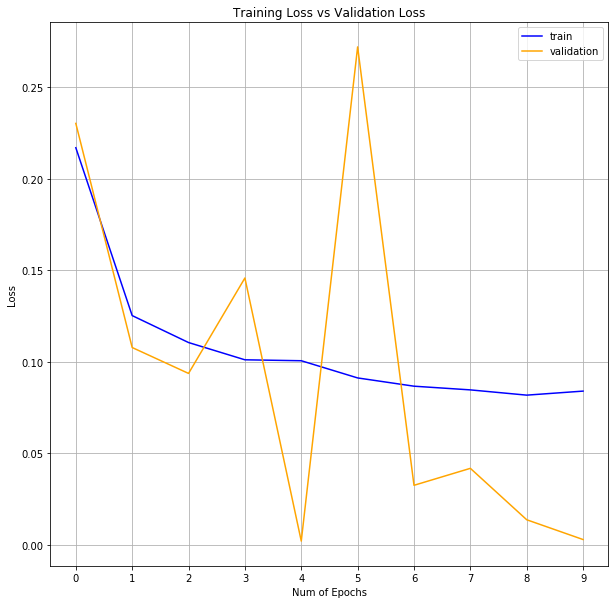

In [145]:

# Plotar a acurácia/desempenho do modelo de acordo com as épocas, comparando traino da validação
fig = plt.figure(figsize=(12,8))
plt.plot(history.history['acc'],'blue')
plt.plot(history.history['val_acc'],'orange')
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(0.8,1.1,.05))
plt.rcParams['figure.figsize'] = (10, 10)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.grid(True)
plt.gray()
plt.legend(['train','validation'])
plt.show()
 
plt.figure(1)
plt.plot(history.history['loss'],'blue')
plt.plot(history.history['val_loss'],'orange')
plt.xticks(np.arange(0, 10, 1))
plt.rcParams['figure.figsize'] = (10, 10)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.grid(True)
plt.gray()
plt.legend(['train','validation'])
plt.show()

In [134]:
#melhorando o modelo utilizando o VGG16 
#include_top = False: carregar VGG sem a parte classificadora do modelo
model_vg=VGG16(weights='imagenet',include_top=False,input_shape=(32, 32, 3))
model_vg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [135]:
# Não altera os pesos da VGG
model_vg.trainable = False

In [136]:
#CNN com utilização de transfer learning
from keras.layers import Activation, Dropout, Flatten, Dense,Conv2D,Conv3D,MaxPooling2D,AveragePooling2D,BatchNormalization
model2 = models.Sequential()
model2.add(model_vg)

model2.add(Flatten())
model2.add(Dense(256, use_bias=True))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Dropout(0.5))
model2.add(Dense(64,activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(16, activation='tanh'))
model2.add(Dense(1, activation='sigmoid'))





In [137]:
# Compilando a rede
 
with tf.device('/GPU:0'):
    model2.compile(optimizer='Adamax', loss='binary_crossentropy', metrics=['acc'])


In [138]:
# steps_per_epoch: Quantas amostras são extraídas do gerador para prosseguir para a próxima época.Após a extração do lote de amostras do gerador(ou seja, depois de executar as etapas do gradiente descendente que procura localizar o mínimo global da funcao) inicia-se a próxima época.
# função de custa 
# Executando o treinamento 
#loss(baseado no treino):valor da função de custo
#val_loss(Baseado na validação):Se Val_loss for significamente maior, significa que houve overfiting no treinamento
with tf.device('/GPU:0'):
    history_vgg=model2.fit_generator(train_generator,steps_per_epoch=1000,epochs=15,validation_data=validation_generator,validation_steps=700)


Epoch 1/15
1000/1000 [==============================] - 57s 57ms/step - loss: 0.1693 - acc: 0.9358 - val_loss: 0.1180 - val_acc: 0.9463
Epoch 2/15
1000/1000 [==============================] - 51s 51ms/step - loss: 0.1205 - acc: 0.9539 - val_loss: 0.0166 - val_acc: 0.9659
Epoch 3/15
1000/1000 [==============================] - 52s 52ms/step - loss: 0.1119 - acc: 0.9579 - val_loss: 0.0225 - val_acc: 0.9653
Epoch 4/15
1000/1000 [==============================] - 51s 51ms/step - loss: 0.1064 - acc: 0.9595 - val_loss: 0.1486 - val_acc: 0.9673
Epoch 5/15
1000/1000 [==============================] - 50s 50ms/step - loss: 0.0991 - acc: 0.9627 - val_loss: 0.1295 - val_acc: 0.9705
Epoch 6/15
1000/1000 [==============================] - 46s 46ms/step - loss: 0.0965 - acc: 0.9642 - val_loss: 0.1243 - val_acc: 0.9673
Epoch 7/15
1000/1000 [==============================] - 52s 52ms/step - loss: 0.0937 - acc: 0.9661 - val_loss: 0.0281 - val_acc: 0.9729
Epoch 8/15
1000/1000 [==========================

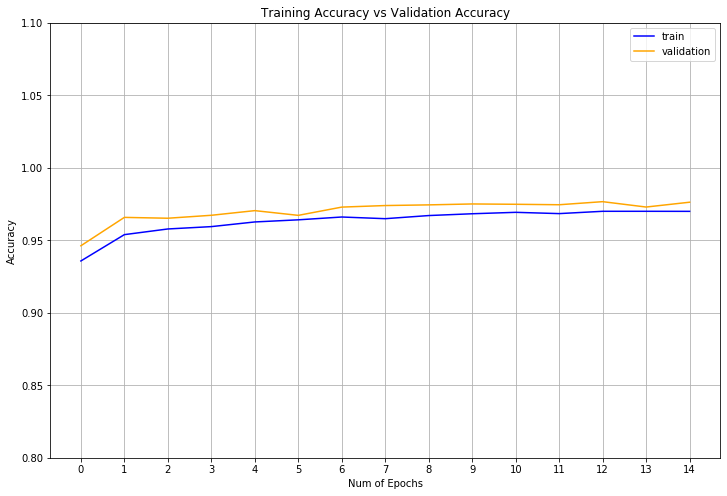

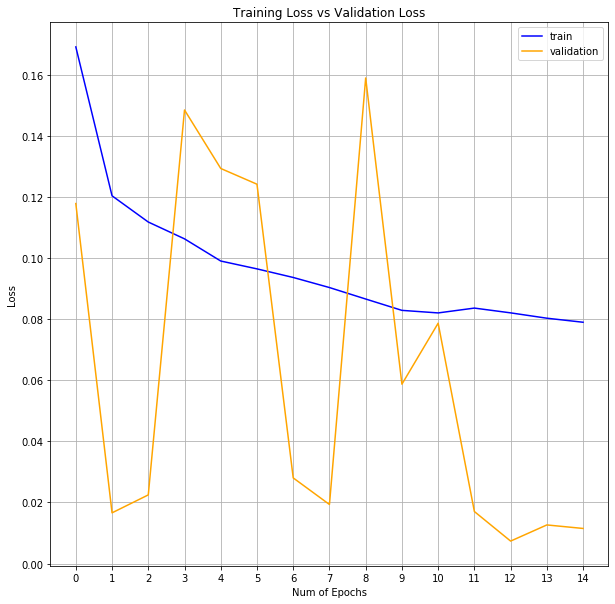

In [147]:
# Plotar a acurácia/desempenho do modelo de acordo com as épocas, comparando traino da validação
fig = plt.figure(figsize=(12,8))
plt.plot(history_vgg.history['acc'],'blue')
plt.plot(history_vgg.history['val_acc'],'orange')
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(0.8,1.1,.05))
plt.rcParams['figure.figsize'] = (10, 10)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.grid(True)
plt.gray()
plt.legend(['train','validation'])
plt.show()
 
plt.figure(1)
plt.plot(history_vgg.history['loss'],'blue')
plt.plot(history_vgg.history['val_loss'],'orange')
plt.xticks(np.arange(0, 15, 1))
plt.rcParams['figure.figsize'] = (10, 10)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.grid(True)
plt.gray()
plt.legend(['train','validation'])
plt.show()

In [148]:
#exportar o resultado(VGG- Transfer Learning):
test_df = pd.read_csv('../cactus/sample_submission.csv')

X_test = []
imges = test_df['id'].values

for img_id in imges:
    X_test.append(cv2.imread(test_dir + img_id )) 
                  
X_test = np.asarray(X_test)
X_test = X_test.astype('float32')
X_test /= 255

y_test_pred  = model2.predict_proba(X_test)

test_df['has_cactus'] = y_test_pred
test_df.to_csv('submission.csv', index=False)

In [ ]:
#exportar o resultado:
test_df = pd.read_csv('../cactus/sample_submission.csv')

X_test = []
imges = test_df['id'].values

for img_id in imges:
    X_test.append(cv2.imread(test_dir + img_id )) 
                  
X_test = np.asarray(X_test)
X_test = X_test.astype('float32')
X_test /= 255

y_test_pred  = model.predict_proba(X_test)

test_df['has_cactus'] = y_test_pred
test_df.to_csv('ML_CNN.csv', index=False)